# Classification of cardiomyocites based on their action potentials
In this lab experience we will be looking at the problem of classifying cardiac cells by looking at
their _Action Potentials_ (APs). For the purpose of this task we will be using synthetically
generated APs following the models in [(Nygren et. al, 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et. al, 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).

### Objectives
By the end of this session you should be able to use nearest-neighbor and simple neural network classifiers for two-class classification problems.

* _Note: Everything below this line should be truned in as part of your lab report._


In [153]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random as rnd
import torch
from sklearn.preprocessing import MinMaxScaler

# inline plots
%matplotlib inline

# set random number generator seed
rnd.seed(10)

# mount GDrive
from google.colab import drive
drive.mount('gdrive/')

# ============================================================================
# data loading
# ============================================================================

# PLEASE, SPECIFY YOUR PATH TO THE DATA HERE
datapath = 'gdrive/My Drive/bmdslab/lab-02/'

# get the list of files to process
matfile = '/'.join((datapath,'Adult_samples.mat'))

# get data as dictionary
adata = scipy.io.loadmat(matfile)

# see the keys of the dictionary 'Vatrial' and 'Vventricular'
# adata['Vatrial'] contains action potentials of cardiac cells of atrial type
# adata['Vventricular'] contains action potentials of cardiac cells of ventricular type
adata.keys()


Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).


dict_keys(['__header__', '__version__', '__globals__', 'Vatrial', 'Vventricular'])

(347, 1000)


Text(0.5, 0, 'sample')

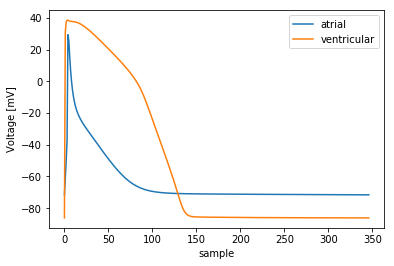

In [154]:
# look at the data dimensions
print(adata['Vatrial'].shape)

# let's see how the data looks like
plt.plot(adata['Vatrial'][:,0])
plt.plot(adata['Vventricular'][:,0])
plt.legend(('atrial','ventricular'))
plt.ylabel('Voltage [mV]')
plt.xlabel('sample')



### Task 1. Pre-processing and manual feature extraction
In this first part we will be normalizing the data and extracting hand-crafted features that will be later
used for the classification task. Load the dataset **Adult_samples.mat** that contains examples of
adult atrial and ventricular action potentials generated using the models in [(Nygren et al., 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et al., 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).
For each of the two classes there are $1000$ samples generated with a sampling rate of $f_s=500$ Hz.

* _(15 points) Data preparation and normalization._
Split the data between test and training sets by
randomly selecting $10\%$ of the points as your training set. Make sure the two classes are well represented
in the training set (e.g., use the same number for both). Normalize the data so that each AP has zero resting potential and unit maximum amplitude. Create an array of corresponding labels for the data points. For ventricular type use the class label $+1$ and $-1$ for
atrial type.
Make two plots displaying your normalized training data for each of the classes. Use time units for the horizontal axis.

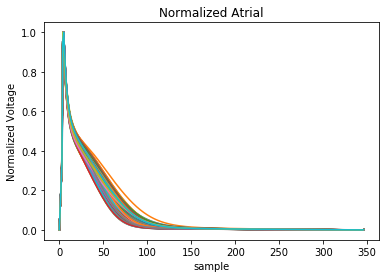

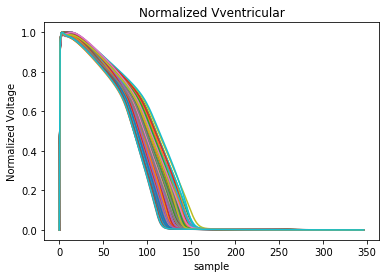

In [155]:
np.random.seed(0)



normalized_Vatrial = np.zeros((347,1000))
normalized_Vventricular = np.zeros((347,1000))
scaler = MinMaxScaler(copy = True, feature_range=(0,1))
normalized_Vatrial = scaler.fit_transform(adata['Vatrial'])
normalized_Vventricular = scaler.fit_transform(adata['Vventricular'])

train_fraction  = 0.10
temp_list = list(range(0,1000))
sample = rnd.sample(temp_list, 100)
temp_sample = np.asarray(sample)
test_indices = [True]*1000
for i in range(1000):
  if i in sample:
    test_indices[i] = False
Vatrial_train = normalized_Vatrial[: ,sample]
Vventricular_train = normalized_Vventricular[: ,sample]
Vatrial_test = normalized_Vatrial[: , test_indices]
Vventricular_test = normalized_Vventricular[: , test_indices]


plt.figure()
plt.plot(Vatrial_train[:,:])
plt.title('Normalized Atrial')
plt.ylabel('Normalized Voltage')
plt.xlabel('sample')

plt.figure()
plt.plot(Vventricular_train[:,:])
plt.title('Normalized Vventricular')
plt.ylabel('Normalized Voltage')
plt.xlabel('sample')

train = np.concatenate((Vatrial_train, Vventricular_train), axis = 1)
test = np.concatenate((Vatrial_test, Vventricular_test), axis = 1)
labels = np.zeros(train.shape[1])
for i in range(int(train.shape[1]/2)):
  labels[i] = -1
  labels[train.shape[1] - 1 - i] = 1
test_labels = np.zeros(test.shape[1])
for i in range(int(test.shape[1]/2)):
  test_labels[i] = -1
  test_labels[test.shape[1] - 1 - i] = 1


* _(20 points) Hand-crafted features._
The _Action Potential Duration_ (APD) at $x\%$ is defined as the time
it takes to reduce the maximum amplitude of the AP to $x\%$ of its value. Write a function that computes APD at a given
percentage $x\in[0,1]$. Compute also the _Average of the Action Potential_ (AAP) and build two-dimensional features
by concatenating APD@$0.5$ and AAP. Make a scatter plot of the training data using these two features. Use
different colors and/or markers to represent each class.

    * Based on your scatter plot, is the training data using the above features linearly separable? Why?

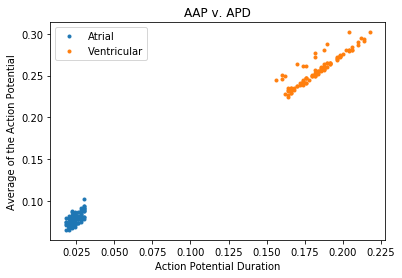

In [156]:
# ============================================================================
# compute hand-crafted features such as APA and APDx
# ============================================================================
#print(train.shape)
def apdx(X,alpha=0.5,fs=500.0):
    """
    This function computes the APDx feature defined as the time it takes to
    reduce the action potential to x% of its maximum value.
    Use:
        APD = apdx(X,alpha,fs)
        
    Inputs:
        X : data points (each column is a data point)
        alpha : [0,1] percentage of maximum amplitude
        fs : sampling frequency (to map samples to time)
        
    Output:
        APD feature
    """
  
    # write your function code here
    # ...
    maxAmpIndex = np.argmax(X)
    #print("Max index: ",maxAmpIndex)
    targetVal = X[maxAmpIndex]*alpha
    #print("Target:",targetVal)

    for i in range(maxAmpIndex, len(X)):
      if abs(X[i] - targetVal)<0.01:
        targetIndex = i

    return((targetIndex - maxAmpIndex) * (1/fs))

def aapx(X):
    return sum(X)/len(X)
'''
print(apdx(train[:,0], 0.5, 500))
print(aapx(train[:,0]))
      
apd_values_A = [0] * len(Vatrial_train[0])
apd_values_V = [0] * len(Vatrial_train[0])
aap_values_A = [0] * len(Vatrial_train[0])
aap_values_V = [0] * len(Vatrial_train[0])
for i in range(len(Vatrial_train[0])):
  apd_values_A[i] = apdx(Vatrial_train[: , i], 0.5, 500)
  apd_values_V[i] = aapx(Vatrial_train[: , i])
  aap_values_A[i] = apdx(Vventricular_train[: , i], 0.5, 500)
  aap_values_V[i] = aapx(Vventricular_train[: , i])
A_Concat = np.zeros((100,2))
V_Concat = np.zeros((100,2))
for i in range(len(apd_values_A)):
  A_Concat[i,0] = apd_values_A[i]
  A_Concat[i,1] = aap_values_A[i]
  V_Concat[i,0] = apd_values_V[i]
  V_Concat[i,1] = aap_values_V[i]
plt.figure()
plt.scatter(A_Concat[:,0], A_Concat[:,1], color = 'blue' )
plt.scatter(V_Concat[:,0], V_Concat[:,1], color = 'red' )
plt.legend([''])
'''
apd_values_A = [0]*len(Vatrial_train[0])
apd_values_V = [0]*len(Vventricular_train[0])
aap_values_A = [0]*len(Vatrial_train[0])
aap_values_V = [0]*len(Vventricular_train[0])

apd_test_A = [0]*len(Vatrial_test[0])
apd_test_V = [0]*len(Vventricular_test[0])
aap_test_A = [0]*len(Vatrial_test[0])
aap_test_V = [0]*len(Vventricular_test[0])

for i in range(len(Vatrial_train[0])):
  apd_values_A[i] = apdx(Vatrial_train[:,i], 0.5, 500)
  aap_values_A[i] = aapx(Vatrial_train[:,i])
  apd_values_V[i] = apdx(Vventricular_train[:,i], 0.5, 500)
  aap_values_V[i] = aapx(Vventricular_train[:,i])
  
for i in range(len(Vatrial_test[0])):
  apd_test_A[i] = apdx(Vatrial_test[:,i], 0.5, 500)
  aap_test_A[i] = aapx(Vatrial_test[:,i])
  apd_test_V[i] = apdx(Vventricular_test[:,i], 0.5, 500)
  aap_test_V[i] = aapx(Vventricular_test[:,i])

combined_A = np.zeros((100,2))
combined_V = np.zeros((100,2))

combined_test_A = np.zeros((900,2))
combined_test_V = np.zeros((900,2))

for i in range(len(apd_values_A)):
  combined_A[i,0] = apd_values_A[i]
  combined_A[i,1] = aap_values_A[i]
  combined_V[i,0] = apd_values_V[i]
  combined_V[i,1] = aap_values_V[i]
  
for i in range(len(apd_test_A)):
  combined_test_A[i,0] = apd_test_A[i]
  combined_test_A[i,1] = aap_test_A[i]
  combined_test_V[i,0] = apd_test_V[i]
  combined_test_V[i,1] = aap_test_V[i]

combined_train = np.concatenate((combined_A, combined_V), axis = 0)
combined_test = np.concatenate((combined_test_A, combined_test_V), axis = 0)
plt.figure()
plt.plot(combined_A[:,0], combined_A[:,1], ".")
plt.plot(combined_V[:,0], combined_V[:,1], ".")
plt.title('AAP v. APD')
plt.xlabel('Action Potential Duration')
plt.ylabel('Average of the Action Potential')
plt.legend(['Atrial','Ventricular'])

###According to the scatter plot, the data is very easily separable because a line (infinitely many different lines in this case) can split the data into the two seperate classifications

### Task 2. Classification

* _(15 points) Nearest-neighbor classifier._
Implement a $1$NN classifier using the Euclidean distance. A $1$NN classifier works as follows: Given your training dataset $\mathcal{D} = \big\{(\boldsymbol x_i,y_i)\big\}_{i=1}^{N}$,where $N$ is the number of training samples, $\boldsymbol x_i\in\mathbb{R}^D$ is a feature vector and $y_i\in\{-1,1\}$ its associated label, and a novel sample $\boldsymbol x$, the $1$NN classifier assigns to $\boldsymbol x$ the same label as its closest point in the training set. That is, the estimated label $\widehat y$ of $\boldsymbol x$ is such that:

\begin{equation}
	\widehat y(\boldsymbol x) = y_{k^*},\quad k^* = \underset{i\in\{1,\ldots,N\}}{\arg\min}\, \lVert \boldsymbol x_i - \boldsymbol x \rVert_2.
\end{equation}

Compute and display the classification accuracy over the test set using the handcrafted training features of **Task 1**.

In [157]:
# ============================================================================
# Nearest-neighbor classifier
# ============================================================================

def nn_classify(Xtest,Xtrain,ytrain):
    """
    This function implements a nearest neighbor classifier.
    Use:
        yhat = nn_classify(Xtest,Xtrain,ytrain)
        
    Inputs:
        Xtest  : test data points (each column is a data point)
        Xtrain : training data points
        ytrain : associated labels to the training data points
        
    Output:
        yhat : estimated labels for the test data.

    """

    yhat = [0] * len(Xtest[:,0])
    for i in range(len(Xtest[:,0])):
      temp_2 = np.zeros((len(Xtrain[:,0]),2))
      temp_1 = np.zeros((len(Xtrain[:,0])))
      for j in range(len(Xtrain[:,0])):
        temp_2[j, 0] = Xtrain[j,0] - Xtest[i,0]
        temp_2[j, 1] = Xtrain[j,1] - Xtest[i,1]
        temp_1[j] = abs(temp_2[j,0]**2 + temp_2[j,1]**2)
      k = np.argmin(temp_1)
      yhat[i] = ytrain[k]
    return yhat 
      #yhat[i] = ytrain[k];
y_hat = nn_classify(combined_test, combined_train, labels)
total = 0;
for i in range(len(y_hat)):
  if y_hat[i] == test_labels[i]:
    total += 1
Accuracy = total / len(y_hat)
print("The Accuracy Is %F" %Accuracy)

The Accuracy Is 1.000000


* _(40 points) Two-layer Neural Network._
 Implement a two-layer neural network classifier of the form:

   $$\widehat y = \operatorname{sign}\big(f_{\theta}(\phi(\boldsymbol x))\big),\quad f_{\theta}(\phi(\boldsymbol x)) = \boldsymbol w^T\phi(\boldsymbol x) + b,\quad \theta = \left[\begin{array}{c}\boldsymbol w\\b\end{array}\right],$$
  
 where $f_\theta(\cdot)$ is a _linear prediction function_ (i.e., classification layer) parametrized by $\theta = [\boldsymbol w^T, b]^T$. The feature extraction part of the network consists of a linear layer followed by a ReLu (rectified linear unit) non-linearity:
 
 $$ \phi(x) = \operatorname{ReLu}\big(\boldsymbol W_1 \boldsymbol x + \boldsymbol b_1\big),\quad\operatorname{ReLu}(x)=\begin{cases}x &x>0\\0&\textrm{else}\end{cases}.$$
 
 In order to find the network's parameters $\Theta=\{\boldsymbol W_1, \boldsymbol b_1, \boldsymbol w, b\}$ minimize the following _regularized empirical risk_ using PyTorch:

   $$\min_{\Theta}\, \underbrace{\frac{1}{N} \sum_{i=1}^N L\big(f_\theta(\phi(\boldsymbol x_i)),y_i\big) + \lambda\big(\frac{1}{w}\lVert \boldsymbol w\rVert^2 + \frac{1}{W}\lVert\boldsymbol W_1\rVert^2\big)}_{C(\Theta)}$$
    
 where the loss function $L(f, y) = \lVert y-f\rVert_2^2)$ is the quadratic (square) loss, and $w,W$, are the number of elements in $\boldsymbol w$ and $\boldsymbol W$, respectively. 

    * Define a network model in PyTorch according to the definition above. For that purpose you can use `torch.nn.Sequential`. Follow this [example](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-nn) to learn how to use it.
    
    * Run a gradient descent algorithm to minimize the cost function using $\lambda =1$. Carefully choose the stepsize and number of iterations until you see the method converges (i.e., the cost function gets to a "plateau").
    
    * Make a scatter plot of the learned features (i.e., prior to classificaiton layer) by your network model. Has your model learned features that are linearly separable? Display in the scatter plot the decision boundary that you have learned. Compute the classification accuracy over the test set.
    
    * Plot the weights of the learned linear layer. What has your network learned?



99 1.013615608215332
199 0.9421615600585938
299 0.8946000933647156
399 0.8520343899726868
499 0.81409752368927
599 0.7800424098968506
699 0.7491980791091919
799 0.7211470603942871
899 0.6956394910812378
999 0.6724669933319092
1099 0.6514535546302795
1199 0.6324235200881958
1299 0.6151797771453857
1399 0.5995715260505676
1499 0.5854306817054749
1599 0.5726090669631958
1699 0.5609829425811768
1799 0.5504395961761475
1899 0.5408706665039062
1999 0.53216952085495
2099 0.5242505073547363
2199 0.5170363783836365
2299 0.5104612708091736
2399 0.5044655203819275
2499 0.4989789128303528
2599 0.49397361278533936
2699 0.4893944263458252
2799 0.4851890504360199
2899 0.4813269078731537
2999 0.47778964042663574
3099 0.4745437502861023
3199 0.47155940532684326
3299 0.46882158517837524
3399 0.46629953384399414
3499 0.4639813303947449
3599 0.46184852719306946
3699 0.45988309383392334
3799 0.45807212591171265
3899 0.456390380859375
3999 0.4548335075378418
4099 0.4533981680870056
4199 0.452060341835022
42

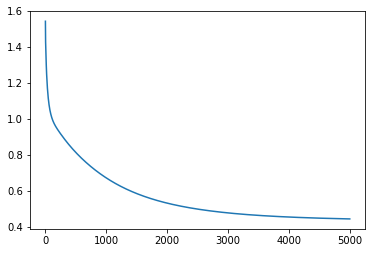

In [158]:
import torch 
N, D_in, H, D_out = train.shape[0], 347, 2, 1

#train is patients by 347 
#train_lab is already there 
x_training = torch.tensor(np.transpose(train), dtype = torch.float)
y_training = torch.tensor(np.transpose(labels), dtype = torch.float)


lev1 = torch.nn.Linear(D_in, H)
lev2 = torch.nn.ReLU()
lev3 = torch.nn.Linear(H, D_out)

model = torch.nn.Sequential(
  lev1, 
  lev2, 
  lev3,
)


def loss(y_pred, y, W, w):
  N = y_pred.shape[0]
  y_pred = torch.squeeze(y_pred)
  lam_1 = 1
  quad = (y_pred - y)**2
  sec = lam_1 * (1/w.shape[0] * torch.norm(w)**2 + 1/W.shape[0] * torch.norm(W)**2)
  function = (1/N) * torch.sum(quad) + sec
  return function 


losses = []
eta = 1e-2

#loss_fn = torch.nn.MSELoss(reduction='mean')  + l + (1/w_element * nolinalg.norm(w)**2 + 1/W_element * np.linalg.norm(W)**2)

for i in range(5000):
  y_pred = model(x_training)
  los = loss(y_pred, y_training, lev3.weight, lev1.weight)
  losses.append(los)
  if i % 100 == 99:
    print(i, los.item())
  
  model.zero_grad()
  los.backward()
  with torch.no_grad():
    for param in model.parameters():
      param -= eta * param.grad

      
y_pred = torch.sign(y_pred)


plt.plot(losses)


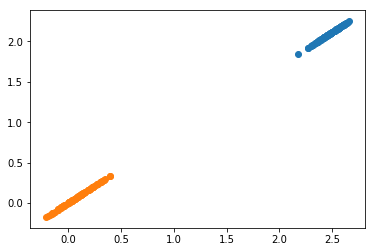

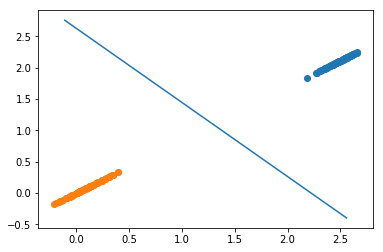

In [159]:
w_net = np.transpose(lev1.weight.detach().numpy())
nn_features = np.matmul(x_training, w_net)

bias =  lev1.bias.detach().numpy()

num = int(x_training.shape[0]/2) 
plt.figure()
plt.scatter(nn_features[0:num, 0] + bias[0], nn_features[0:num, 1] + bias[1])
plt.scatter(nn_features[num:, 0] + bias[0], nn_features[num:, 1] + bias[1])


plt.figure()
plt.scatter(nn_features[0:num, 0] + bias[0], nn_features[0:num, 1] + bias[1])
plt.scatter(nn_features[num:, 0] + bias[0], nn_features[num:, 1] + bias[1])
x_plot = np.linspace(max(nn_features[0:num, 0] + bias[0]) - 0.1,min(nn_features[num:, 0] + bias[0])+0.1)
w = lev3.weight
w_plot = np.asarray(w.detach())
b_plot = np.asarray(lev3.bias.detach())
plt.plot(x_plot, (x_plot * -w_plot[:,0] - b_plot)/w_plot[:,1])
'''
Gavin:
you're trying to find the line that solves the equation w_1*x + w_2 * y + b = 0
w_1 is the first weight of the last layer, and w_2 is the second
and b is the bias
take a linspace vector of x's and compute the corresponding y's with that equation and the plot them against each other
'''

plt.show()

My model has learned featyres that are linearly separable. It can be seen on the graph as a decision boundary could easily split the plot of the two separate outcomes completely. This case is very easy to see as the two groupings are very far separated.

In [160]:

test_ten = torch.tensor(np.transpose(test), dtype = torch.float)
y_test = model(test_ten)


y_test = torch.sign(y_test)

nn_acc =np.mean(torch.squeeze(y_test).detach().numpy() == test_labels)

print("The accuracy is %f" %nn_acc)

The accuracy is 1.000000


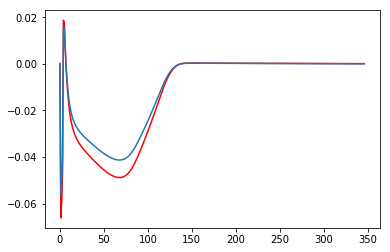

In [164]:
plt.plot(lev1.weight[0].detach().numpy(), 'red')
plt.plot(lev1.weight[1].detach().numpy())

plt.show()

The model has learned how to make the relative weights so that it can predict with 100% accuracy. It can be seen that the value of the first level's first weight is typically less than that of the second.